In [1]:
import numpy as np
import pandas as pd
import datetime
data_path = '/home/suibe/dev_sjl/毕业论文/data/'
ad_features = pd.read_csv(data_path + 'ad_feature.csv')
raw_sample = pd.read_csv(data_path + 'raw_sample.csv')
user_profile = pd.read_csv(data_path + 'user_profile.csv')
behavior_log = pd.read_csv(data_path + 'behavior_log.csv')

In [2]:
#处理原始数据
raw_sample.rename(columns={'user': 'user_id'}, inplace=True)
raw_sample['time_stamp'] = pd.to_datetime(raw_sample['time_stamp'], unit='s')
raw_sample.drop(columns=['nonclk'], inplace = True)

In [3]:
raw_sample

,user_id,time_stamp,adgroup_id,pid,clk
0,581738,2017-05-07 06:14:04,1,430548_1007,0
1,449818,2017-05-13 01:26:18,3,430548_1007,0
2,914836,2017-05-13 04:47:59,4,430548_1007,0
3,914836,2017-05-13 04:50:29,5,430548_1007,0
4,399907,2017-05-09 04:09:18,8,430548_1007,0
...,...,...,...,...,...
26557956,6834,2017-05-07 06:52:29,846808,430548_1007,0
26557957,16815,2017-05-09 11:14:35,846808,430548_1007,0
26557958,736609,2017-05-12 14:04:31,846809,430548_1007,0
26557959,735781,2017-05-13 14:09:10,846809,430539_1007,0


In [4]:
user_profile

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,NaN,3,0,3.0
1,523,5,2,2,2,1.0,3,1,2.0
2,612,0,8,1,2,2.0,3,0,NaN
3,1670,0,4,2,4,NaN,1,0,NaN
4,2545,0,10,1,4,NaN,3,0,NaN
...,...,...,...,...,...,...,...,...,...
1061763,1137955,0,3,2,3,NaN,3,0,4.0
1061764,1138545,0,4,2,4,NaN,3,0,3.0
1061765,1138902,67,9,1,3,2.0,3,0,4.0
1061766,1139632,0,7,1,1,NaN,1,0,NaN


In [5]:
behavior_log.head(1000)

,user,time_stamp,btag,cate,brand
0,558157,1493741625,pv,6250,91286
1,558157,1493741626,pv,6250,91286
2,558157,1493741627,pv,6250,91286
3,728690,1493776998,pv,11800,62353
4,332634,1493809895,pv,1101,365477
...,...,...,...,...,...
995,550317,1493813197,pv,2528,119338
996,288293,1493815319,pv,2528,119338
997,184795,1493773199,pv,2528,119338
998,390386,1493765111,pv,2528,119338


In [10]:
behivor_cnt = behavior_log.groupby(['user']).size().reset_index(name='count').sort_values(by = 'count', ascending=False)

<AxesSubplot:ylabel='Density'>

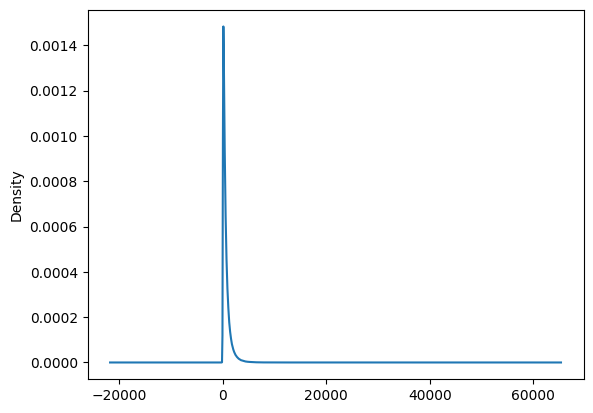

In [11]:
behivor_cnt['count'].plot(kind='kde')

In [6]:
ad_features

,adgroup_id,cate_id,campaign_id,customer,brand,price
0,63133,6406,83237,1,95471.0,170.00
1,313401,6406,83237,1,87331.0,199.00
2,248909,392,83237,1,32233.0,38.00
3,208458,392,83237,1,174374.0,139.00
4,110847,7211,135256,2,145952.0,32.99
...,...,...,...,...,...,...
846806,824255,4526,380022,255868,389713.0,268.00
846807,790170,4280,379736,255872,322171.0,68.00
846808,845286,6261,379736,255872,322171.0,88.00
846809,824732,4520,379736,255872,322171.0,68.00
